In [2]:
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as units
import networkx as nx 
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import haversine_distances
from joblib import Parallel, delayed
from collections import defaultdict
from rapidfuzz import fuzz
from sklearn.preprocessing import MultiLabelBinarizer

In [5]:


def matches_deduplication(blocked_df, name_thres, spatial_tresh, temp_thresh,parallel):
    G = nx.Graph()
    G.add_nodes_from(blocked_df.index)
    coord_groups = defaultdict(list)

    # Group by coord_block
    for idx, row in blocked_df.iterrows():
        coord_groups[row['coord_block']].append(idx)
    # coord_groups = [(block, group.index) for block, group in blocked_df.groupby('coord_block').groups.items()]
    # coord_groups = blocked_df.groupby('coord_block').indices.items()
    # Process each group
    for coord_block, indices in coord_groups.items():
        group = blocked_df.loc[indices]
        if len(group) == 1:
            continue
        
        
        
        
    # Vectorized spatial and temporal differences
        coords = group[['s_ra', 's_dec']].values
        coords_rad = np.radians(coords)
        # Compute pairwise Haversine distances (returns in radians)
        spatial_dists = haversine_distances(coords_rad)
        # Convert to degrees for your threshold (e.g., 1 arcminute = 0.0167 degrees)
        spatial_dists = np.degrees(spatial_dists)
        
        
        times = group['MJD-OBS'].values
        time_diffs = squareform(pdist(times[:, None]))

        # Name similarities
        names = group['target_name'].values
        name_sims = np.zeros((len(names), len(names)))
        
        
        # for i in range(len(names)):
        #     for j in range(i + 1, len(names)):
        #         name_sims[i, j] = fuzz.token_sort_ratio(names[i], names[j])
        #         name_sims[j, i] = name_sims[i, j]
        tokenized_names = [name.split() for name in names]
        mlb = MultiLabelBinarizer()
        binary_matrix = mlb.fit_transform(tokenized_names)
        jaccard_dists = pdist(binary_matrix, metric='jaccard')
        name_sims = 1 - squareform(jaccard_dists)  # Similarity matrix (0 to 1)
        
                    
            
            
        
        

        # Apply thresholds
        mask = (spatial_dists <= spatial_tresh) & (time_diffs <= temp_thresh) & (name_sims >= name_thres)
        rows, cols = np.where(mask)
        for r, c in zip(rows, cols):
            if r < c:
                G.add_edge(group.index[r], group.index[c])

    # Extract clusters and representatives
    clusters = [list(c) for c in nx.connected_components(G)]
    print(f"Number of clusters: {len(clusters)}")
    representatives = []
    for cluster in clusters:
        cluster_df = blocked_df.loc[cluster]
        cluster_df = cluster_df.sort_values(['MJD-OBS'], ascending=True)
        representatives.append(cluster_df.iloc[0])

    dedup_df = pd.DataFrame(representatives).reset_index(drop=True)
    print(f"Reduced from {len(blocked_df)} to {len(dedup_df)} unique objects")
    return dedup_df,clusters

#

In [3]:
merged_df = pd.read_csv('merged_df.csv')

merged_df.head()

,target_name,s_ra,s_dec,dataset,MJD-OBS,em,coord_block,temp_block,cluster
0,IRAS-05248-7007,81.086467,-70.083778,JWST,59699.184242,3221.5,"(810, -701)",8528,0
1,J1120+0641,170.006167,6.690083,JWST,59945.244998,1147.5,"(1700, 66)",8563,0
2,CEERS-FULL-V2,214.909666,52.872408,JWST,60389.455668,2950.0,"(2149, 528)",8627,0
3,GOODSS2009,53.052791,-27.731936,JWST,60231.322527,2950.0,"(530, -278)",8604,0
4,ABELL2744,3.594322,-30.395694,JWST,60132.288682,3560.0,"(35, -304)",8590,0


Let's pass the merged file again trough the deduplication algorithm to see if we find any duplicates now comparing from instrument to instrument instead of within each facility.

In [6]:
merged2,clusters = matches_deduplication(merged_df, name_thres=0.8, spatial_tresh=1, temp_thresh=7, parallel=False) 

Number of clusters: 9163
Reduced from 9807 to 9163 unique objects


In [7]:
print(merged2.head())
print(clusters[:5])

       target_name        s_ra      s_dec dataset       MJD-OBS      em  \
0  IRAS-05248-7007   81.086467 -70.083778    JWST  59699.184242  3221.5   
1       J1120+0641  170.006167   6.690083    JWST  59945.244998  1147.5   
2    CEERS-FULL-V2  214.909666  52.872408    JWST  60382.702982  2950.0   
3       GOODSS2009   53.052791 -27.731936    JWST  60231.322527  2950.0   
4        ABELL2744    3.594322 -30.395694    JWST  60132.288682  3560.0   

   coord_block  temp_block  cluster  
0  (810, -701)        8528        0  
1   (1700, 66)        8563        0  
2  (2149, 528)        8626        0  
3  (530, -278)        8604        0  
4   (35, -304)        8590        0  
[[0], [1], [2, np.int64(260)], [3], [4]]


Chaging spatial_tresh and name_trhes around lead to no difference in the number of clusters, but changing  temp_thresh does. If we increasethe limit for temporal diffirence (like within 7 days, 14, days, 90 days etc) we noticed the unique objects reducing but this is tricky because the instruments were not all running at the same time for the same time. JWST is the most recent and TESS is the oldest of them. So just loosing the temporal difference does not necessairly by it self tell us more about an object. Its just older. That is why we need to move onto Data Fusion strategies so we can deal with issues like this like time relevance where the same object can be observed at extremely different times, but we only need one of them. This will be one of the 6 strategies we will apply.

# Data Fusion


**Possible strategies, can change later**

### More specific strategies

**1. Temporal recency** - As said previously some facilities are more recent than others, so we intend to give priority to more recent observations as we believe in their technical evolution and cablibration over older instrumets. (e.g. The JWST is only roughly 3 and half years while TESS has been working for 7 years, ALMA for 12 years and HAWKI for 18 years)

**2. Instrument Weighted Conflict resolution** - Some instruments are more specialized in a given range in the eletromagnectic spectrum, so it makes sense for us to give priority to the more specialized insturment when the given eletromagnetic wave falls within the correspondant range the instrument is expert at. We can either set hard ranges for these eletromagnetic conflicts or we can have a more loose range and give weights to each. Problably first is easier to do.

**3. Spatial proximity resolution** - Since one of our objectives is to be able to find possible space clusters of objects, we intend to facilitate this by optimizing the spacial coherence. We could do this by choosing the object whose coordinates minimize the distance between that given entity and its k(3,5 or 10 but we need to test) nearest neighbours. Ideally this would make cluster more tight and ooutliers stand out more.

### More general strategies

**4. Weighted Average** - In the event we have still multiple objects with similar numerical values, but no resolution was made trough the previous methods, we could just take an average of their values. We believe this is possible because even though each isntrument is different, we had the attention to normalize the units all of the relevant variables for our study.

**5. Majority vote** - For the target_name variable we can apply for example a majority vote between instruments on if they see the same object but each give diffeent names we can choose the ones that appear the most.

**6. Random Selection** - Finally when eveything else fails we can resort to random selection when trying to solve a conflict. Although not ideal its the last resort at a cleaner unified dataset.


**The ideas are 100% ours but we will use copilot help to perfect the actual implementtion of the code**


In [138]:
class DataFusionPipeline:
    def __init__(self, df):
        self.df = df.copy()
        
        self.instrument_ages = {
            'JWST': 1,    # ~3.5 years (newest, highest priority)
            'TESS': 2,    # ~7 years  
            'ALMA': 3,   # ~12 years
            'HAWKI': 4     # ~18 years (oldest, lowest priority)
        }
        
        # Original instrument expertise (keeping for other resolution methods)
        self.instrument_expertise = {
            'TESS': {'min_nm': 600, 'max_nm': 1000, 'priority': 3},
            'HAWKI': {'min_nm': 1100, 'max_nm': 2500, 'priority': 2},
            'JWST': {'min_nm': 600, 'max_nm': 28500, 'priority': 4},
            'ALMA': {'min_nm': 300000, 'max_nm':  10000000, 'priority': 4}
        }




In [139]:
class TemporalResolution(DataFusionPipeline):    
    def temporal_recency_resolution(self, clusters, original_df=None):
        """
        Resolve conflicts using temporal recency based on instrument ages.
        Prioritizes newer instruments over older ones.
        
        """  
        if original_df is None:
            original_df = self.df
        
        # Just some logs for statistics later 
        resolution_log = {
            'total_clusters': len(clusters),
            'objects_before': len(original_df),
            'resolved_by_instrument': {},
            'resolved_by_date': 0,
            'tie_breakers': 0
        }
        
        
        df_copy = original_df.copy()
        
        # Important for vectorized operations down below
        df_copy['instrument_age'] = self._get_instrument_ages_vectorized(df_copy)
        
        
        # indices_to_keep = set(range(len(df_copy)))
        # indices_to_remove = set()
        elimination_details = []  # Store info about eliminated instances for inspection
        
        
        for cluster_idx, cluster in enumerate(clusters):
            if len(cluster) <= 1:
                continue
                
            
            cluster_df = df_copy.iloc[cluster].copy()
            
            # Method 1: Resolve by instrument age (vectorized)
            min_age = cluster_df['instrument_age'].min()
            newest_mask = cluster_df['instrument_age'] == min_age
            newest_indices = cluster_df[newest_mask].index.tolist()
            
            if len(newest_indices) == 1:
                # Single newest instrument wins
                winner_idx = newest_indices[0]
                losers = [idx for idx in cluster if idx != winner_idx]
                winner_age = cluster_df.loc[winner_idx, 'instrument_age']
                winner_date = cluster_df.loc[winner_idx, 'MJD-OBS']
                winner_instrument = self._get_instrument_from_dataset(
                        df_copy.loc[winner_idx, 'dataset']
                    ) 
                
                
                for loser_idx in losers:
                    loser_instrument = self._get_instrument_from_dataset(
                        df_copy.loc[loser_idx, 'dataset']
                    )
                    loser_age = df_copy.loc[loser_idx, 'instrument_age']
                    loser_date = df_copy.loc[loser_idx, 'MJD-OBS']
                    
                    elimination_details.append({'eliminated_idx': loser_idx,
                        'winner_idx': winner_idx,
                        'cluster_id': cluster_idx,
                        'elimination_reason': 'instrument_age',
                        'winner_instrument': winner_instrument,
                        'winner_age': winner_age,
                        'winner_date': winner_date,
                        'loser_instrument': loser_instrument,
                        'loser_age': loser_age,
                        'loser_date': loser_date,
                        'target_name': df_copy.loc[loser_idx, 'target_name'] if 'target_name' in df_copy.columns else None,
                        's_ra': df_copy.loc[loser_idx, 's_ra'] if 's_ra' in df_copy.columns else None,
                        's_dec': df_copy.loc[loser_idx, 's_dec'] if 's_dec' in df_copy.columns else None})
                    
                resolution_log['resolved_by_instrument'][winner_instrument] = \
                    resolution_log['resolved_by_instrument'].get(winner_instrument, 0) + 1
                
            else:
                # Tie in instrument age - resolve by observation date
                newest_cluster_df = cluster_df.loc[newest_indices]
                
                # Get most recent observation date
                if 'MJD-OBS' in newest_cluster_df.columns:
                    max_date_idx = newest_cluster_df['MJD-OBS'].idxmax()
                    winner_idx = max_date_idx
                    resolution_log['resolved_by_date'] += 1
                else:
                    # Fallback: keep first occurrence
                    winner_idx = newest_indices[0]
                    resolution_log['tie_breakers'] += 1
                
                losers = [idx for idx in cluster if idx != winner_idx]
            
        #     # Mark losers for removal
        #     indices_to_remove.update(losers)
        
        # # Remove losers from keep set
        # indices_to_keep -= indices_to_remove
        
        
        
         # Create eliminated dataframe (losers) with detailed information
        if elimination_details:
            # Debug: Check alignment
            elimination_info_df = pd.DataFrame(elimination_details)
            # print(f"DEBUG: elimination_details entries: {len(elimination_details)}")
            # print(f"DEBUG: indices_to_remove: {len(indices_to_remove)}")
            # print(f"DEBUG: First few eliminated_idx: {elimination_info_df['eliminated_idx'].head().tolist()}")
            # print(f"DEBUG: First few indices_to_remove: {list(indices_to_remove)[:5]}")
            # print("\n")
            # Get the eliminated instances data using the indices from elimination_details
            eliminated_indices = elimination_info_df['eliminated_idx'].tolist()
            eliminated_df = df_copy.loc[eliminated_indices].copy()
            eliminated_df = eliminated_df.drop(columns=['instrument_age'])  # Remove helper column
            
            # Reset index and add original index tracking
            eliminated_df = eliminated_df.reset_index(drop=False)
            eliminated_df = eliminated_df.rename(columns={'index': 'original_idx'})
            
            # Add elimination info columns directly (they should be in the same order)
            eliminated_df['eliminated_idx'] = elimination_info_df['eliminated_idx'].values
            eliminated_df['winner_idx'] = elimination_info_df['winner_idx'].values
            eliminated_df['cluster_id'] = elimination_info_df['cluster_id'].values
            eliminated_df['elimination_reason'] = elimination_info_df['elimination_reason'].values
            eliminated_df['winner_instrument'] = elimination_info_df['winner_instrument'].values
            eliminated_df['winner_age'] = elimination_info_df['winner_age'].values
            eliminated_df['winner_date'] = elimination_info_df['winner_date'].values
            
            # # Check if there are indices in indices_to_remove that aren't in elimination_details
            # missing_indices = indices_to_remove - set(eliminated_indices)
            # if missing_indices:
            #     print(F"DEBUG:")
            #     print(f"WARNING: {len(missing_indices)} indices in indices_to_remove but not in elimination_details")
            #     print(f"Missing indices: {list(missing_indices)[:10]}...")  # Show first 10
            #     print("\n")
                
        else:
            # Create empty dataframe with same columns if no eliminations
            eliminated_df = df_copy.iloc[0:0].copy()
            eliminated_df = eliminated_df.drop(columns=['instrument_age'])
            eliminated_df = eliminated_df.reset_index(drop=True)
            # Add elimination info columns
            for col in ['original_idx', 'eliminated_idx', 'winner_idx', 'cluster_id', 'elimination_reason', 
                       'winner_instrument', 'winner_age', 'winner_date']:
                eliminated_df[col] = None
                
        # Create resolved dataframe
        resolved_df = df_copy.drop(index=eliminated_indices, errors='ignore').copy()
        resolved_df = resolved_df.drop(columns=['instrument_age'], errors='ignore')
        resolved_df = resolved_df.reset_index(drop=True)
        
        # Update resolution log
        resolution_log['objects_after'] = len(resolved_df)
        resolution_log['objects_removed'] = len(eliminated_df)
        
        return resolved_df, eliminated_df, resolution_log
    
    def _get_instrument_ages_vectorized(self, df):
        """
        Vectorized function to assign instrument ages based on dataset column.
        """
        # Create age mapping based on dataset names
        age_series = pd.Series(index=df.index, dtype=int)
        
        for instrument, age in self.instrument_ages.items():
            # Check if instrument name appears in dataset column
            mask = df['dataset'].str.contains(instrument, case=False, na=False)
            age_series.loc[mask] = age
        
        # Handle unknown instruments (assign oldest age + 1)
        unknown_mask = age_series.isna()
        if unknown_mask.any():
            age_series.loc[unknown_mask] = max(self.instrument_ages.values()) + 1
            
        return age_series
    
    #Heper function to extract instrument from dataset name
    def _get_instrument_from_dataset(self, dataset_name):
        """
        Extract instrument name from dataset string.
        """
        dataset_upper = str(dataset_name).upper()
        for instrument in self.instrument_ages.keys():
            if instrument.upper() in dataset_upper:
                return instrument
        return 'UNKNOWN'
    
    def get_temporal_resolution_stats(self, resolution_log):
        """
        Print detailed statistics about temporal resolution.
        """
        print("=== TEMPORAL RECENCY RESOLUTION STATISTICS ===")
        print(f"Total clusters processed: {resolution_log['total_clusters']}")
        print(f"Objects before resolution: {resolution_log['objects_before']}")
        print(f"Objects after resolution: {resolution_log['objects_after']}")
        print(f"Objects removed: {resolution_log['objects_removed']}")
        print(f"Reduction rate: {resolution_log['objects_removed']/resolution_log['objects_before']*100:.1f}%")
        print()
        
        print("Resolution by instrument priority:")
        for instrument, count in resolution_log['resolved_by_instrument'].items():
            age = self.instrument_ages.get(instrument, 'Unknown')
            print(f"  {instrument} (age {age}): {count} wins")
        print()
        
        print(f"Resolved by observation date: {resolution_log['resolved_by_date']}")
        print(f"Tie-breaker resolutions: {resolution_log['tie_breakers']}")

In [140]:
# Example usage function
def apply_temporal_resolution(pipeline, clusters, original_df):
    """
    Example of how to apply temporal recency resolution.
    """
    resolved_df, losers_df,log, = pipeline.temporal_recency_resolution(clusters, original_df)
    pipeline.get_temporal_resolution_stats(log)
    
    return resolved_df, losers_df

In [141]:
pipe = TemporalResolution(merged2)
resolved_df,temporal_losers = apply_temporal_resolution(pipe, clusters, merged2)



=== TEMPORAL RECENCY RESOLUTION STATISTICS ===
Total clusters processed: 9163
Objects before resolution: 9163
Objects after resolution: 9130
Objects removed: 33
Reduction rate: 0.4%

Resolution by instrument priority:
  JWST (age 1): 31 wins
  TESS (age 2): 1 wins

Resolved by observation date: 412
Tie-breaker resolutions: 0


In [142]:
resolved_df

,target_name,s_ra,s_dec,dataset,MJD-OBS,em,coord_block,temp_block,cluster
0,IRAS-05248-7007,81.086467,-70.083778,JWST,59699.184242,3221.5,"(810, -701)",8528,0
1,J1120+0641,170.006167,6.690083,JWST,59945.244998,1147.5,"(1700, 66)",8563,0
2,CEERS-FULL-V2,214.909666,52.872408,JWST,60382.702982,2950.0,"(2149, 528)",8626,0
3,GOODSS2009,53.052791,-27.731936,JWST,60231.322527,2950.0,"(530, -278)",8604,0
4,ABELL2744,3.594322,-30.395694,JWST,60132.288682,3560.0,"(35, -304)",8590,0
...,...,...,...,...,...,...,...,...,...
9125,TESS FFI,118.085778,-54.784110,TESS,60703.535902,800.0,"(1180, -548)",8671,0
9126,TESS FFI,110.714292,-66.099514,TESS,60703.534828,800.0,"(1107, -661)",8671,0
9127,TESS FFI,87.465791,-59.730241,TESS,60703.534831,800.0,"(874, -598)",8671,0
9128,TESS FFI,66.291166,-67.405962,TESS,60703.533629,800.0,"(662, -675)",8671,0


In [143]:
temporal_losers

,original_idx,target_name,s_ra,s_dec,dataset,MJD-OBS,em,coord_block,temp_block,cluster,eliminated_idx,winner_idx,cluster_id,elimination_reason,winner_instrument,winner_age,winner_date
0,8137,TESS FFI,199.481158,-63.042173,TESS,60082.163580,800.000000,"(1994, -631)",8583,0,8137,491,452,instrument_age,JWST,1.0,60065.942105
1,7931,TESS FFI,0.706665,39.791467,TESS,58776.691636,800.000000,"(7, 397)",8396,0,7931,498,459,instrument_age,JWST,1.0,60241.434796
2,8158,TESS FFI,90.257227,-47.635129,TESS,59186.726803,800.000000,"(902, -477)",8455,0,8158,1628,1497,instrument_age,JWST,1.0,59792.323994
3,7713,AGAL313.661-01.144,216.257333,-62.050361,ALMA,57832.294934,1381.965445,"(2162, -621)",8261,0,7713,2506,2324,instrument_age,JWST,1.0,60265.462896
4,8268,TESS FFI,353.692591,-56.324540,TESS,58338.743128,800.000000,"(3536, -564)",8334,0,8268,2588,2402,instrument_age,JWST,1.0,60068.831904
5,7704,SKY,217.425000,-62.679444,Hawki,57887.056264,2095.500000,"(2174, -627)",8269,0,7704,2842,2639,instrument_age,JWST,1.0,60396.472391
6,8118,TESS FFI,52.962405,-5.553703,TESS,59156.733649,800.000000,"(529, -56)",8450,0,8118,3103,2884,instrument_age,JWST,1.0,60108.896996
7,7747,ad3a-19338,217.161579,-62.440975,ALMA,59588.526774,3545.153324,"(2171, -625)",8512,0,7747,3385,3144,instrument_age,JWST,1.0,59765.084073
8,7828,TESS FFI,254.336042,61.386337,TESS,58912.395976,800.000000,"(2543, 613)",8416,0,7828,3425,3181,instrument_age,JWST,1.0,60359.039325
9,8201,TESS FFI,241.813062,-71.391880,TESS,60111.550135,800.000000,"(2418, -714)",8587,0,8201,3794,3524,instrument_age,JWST,1.0,60027.190076


In [144]:
class EMrResolution(DataFusionPipeline):
    def em_resolution(self, clusters, original_df=None):
        """
        Resolve conflicts using instrument expertise in the electromagnetic range.
        For each duplicate cluster, choose the instance whose 'em' value is within or
        closest to the instrument's expertise range.
        """
        if original_df is None:
            original_df = self.df

        # Log for resolution statistics
        resolution_log = {
            'total_clusters': len(clusters),
            'objects_before': len(original_df),
            'resolved_by_expertise': {},
            'used_alternative': 0
        }

        df_copy = original_df.copy()

        if 'em' not in df_copy.columns:
            raise ValueError("Column 'em' not found. Make sure an electromagnetic midpoint 'em' column exists.")

        elimination_details = []  # To track eliminated instances

        # Process each duplicate cluster
        for cluster_idx, cluster in enumerate(clusters):
            if len(cluster) <= 1:
                continue

            cluster_df = df_copy.loc[cluster].copy()

            # Compute a score for each instance based on its distance from its instrument's expertise range.
            # Score is 0 if 'em' is within the range; otherwise it is the absolute distance to the closest boundary.
            scores = {}
            for idx, row in cluster_df.iterrows():
                instrument = self._get_instrument_from_dataset(row['dataset'])
                exp = self.instrument_expertise.get(instrument)
                if exp is None:
                    score = float('inf')
                else:
                    min_nm = exp['min_nm']
                    max_nm = exp['max_nm']
                    em_value = row['em']
                    if min_nm <= em_value <= max_nm:
                        score = 0
                    elif em_value < min_nm:
                        score = min_nm - em_value
                    else:  # em_value > max_nm
                        score = em_value - max_nm
                scores[idx] = score

            # Choose the instance with the smallest score as the winner
            winner_idx = min(scores, key=scores.get)
            winner_instrument = self._get_instrument_from_dataset(df_copy.loc[winner_idx, 'dataset'])
            resolution_log['resolved_by_expertise'][winner_instrument] = (
                resolution_log['resolved_by_expertise'].get(winner_instrument, 0) + 1
            )

            # Mark all other instances as eliminated
            for idx in cluster_df.index:
                if idx != winner_idx:
                    elimination_details.append({
                        'eliminated_idx': idx,
                        'winner_idx': winner_idx,
                        'cluster_id': cluster_idx,
                        'elimination_reason': 'em_expertise',
                        'winner_instrument': winner_instrument,
                        'score_winner': scores[winner_idx],
                        'score_eliminated': scores[idx],
                        'em_value': df_copy.loc[idx, 'em']
                    })

        # Build eliminated and resolved DataFrames based on elimination details
        if elimination_details:
            elimination_info_df = pd.DataFrame(elimination_details)
            eliminated_indices = elimination_info_df['eliminated_idx'].unique().tolist()
            eliminated_df = df_copy.loc[eliminated_indices].copy()
            eliminated_df = eliminated_df.reset_index(drop=True)
        else:
            eliminated_df = pd.DataFrame(columns=df_copy.columns)

        resolved_df = df_copy.drop(index=eliminated_indices, errors='ignore').copy()
        resolved_df = resolved_df.reset_index(drop=True)

        resolution_log['objects_after'] = len(resolved_df)
        resolution_log['objects_removed'] = len(eliminated_df)

        return resolved_df, eliminated_df, resolution_log
    
    def _get_instrument_from_dataset(self, dataset_name):
        """
        Extract instrument name from dataset string.
        """
        dataset_upper = str(dataset_name).upper()
        for instrument in self.instrument_ages.keys():
            if instrument.upper() in dataset_upper:
                return instrument
        return 'UNKNOWN'
    
    def get_emr_resolution_stats(self, resolution_log):
        """
        Print detailed statistics about instrument expertise resolution.
        """
        print("=== INSTRUMENT EXPERTISE RESOLUTION STATISTICS ===")
        print(f"Total clusters processed: {resolution_log['total_clusters']}")
        print(f"Objects before resolution: {resolution_log['objects_before']}")
        print(f"Objects after resolution: {resolution_log['objects_after']}")
        print(f"Objects removed: {resolution_log['objects_removed']}")
        reduction_rate = (resolution_log['objects_removed'] / resolution_log['objects_before'] * 100 
                          if resolution_log['objects_before'] else 0)
        print(f"Reduction rate: {reduction_rate:.1f}%")
        print()
        
        print("Resolution by instrument expertise:")
        for instrument, count in resolution_log['resolved_by_expertise'].items():
            print(f"  {instrument}: {count} wins")
        print()
        
        print(f"Used alternative method: {resolution_log['used_alternative']}")

In [145]:
# Example usage function
def apply_em_resolution(pipeline, clusters, original_df):
    """
    Example of how to apply Eltromagnetic expertise resolution.
    """
    resolved_df, losers_df,log, = pipeline.em_resolution(clusters, original_df)
    pipeline.get_emr_resolution_stats(log)
    
    return resolved_df, losers_df

In [146]:
pipe = EMrResolution(resolved_df)
resolved_df2,em_losers = apply_em_resolution(pipe, clusters, resolved_df)

=== INSTRUMENT EXPERTISE RESOLUTION STATISTICS ===
Total clusters processed: 9163
Objects before resolution: 9130
Objects after resolution: 8486
Objects removed: 644
Reduction rate: 7.1%

Resolution by instrument expertise:
  JWST: 419 wins
  TESS: 24 wins
  HAWKI: 1 wins

Used alternative method: 0


In [147]:
resolved_df2

,target_name,s_ra,s_dec,dataset,MJD-OBS,em,coord_block,temp_block,cluster
0,IRAS-05248-7007,81.086467,-70.083778,JWST,59699.184242,3221.5,"(810, -701)",8528,0
1,J1120+0641,170.006167,6.690083,JWST,59945.244998,1147.5,"(1700, 66)",8563,0
2,CEERS-FULL-V2,214.909666,52.872408,JWST,60382.702982,2950.0,"(2149, 528)",8626,0
3,GOODSS2009,53.052791,-27.731936,JWST,60231.322527,2950.0,"(530, -278)",8604,0
4,ABELL2744,3.594322,-30.395694,JWST,60132.288682,3560.0,"(35, -304)",8590,0
...,...,...,...,...,...,...,...,...,...
8481,TESS FFI,118.085778,-54.784110,TESS,60703.535902,800.0,"(1180, -548)",8671,0
8482,TESS FFI,110.714292,-66.099514,TESS,60703.534828,800.0,"(1107, -661)",8671,0
8483,TESS FFI,87.465791,-59.730241,TESS,60703.534831,800.0,"(874, -598)",8671,0
8484,TESS FFI,66.291166,-67.405962,TESS,60703.533629,800.0,"(662, -675)",8671,0


In [148]:
em_losers

,target_name,s_ra,s_dec,dataset,MJD-OBS,em,coord_block,temp_block,cluster
0,LMC-CAL-FIELD,80.490321,-69.498155,JWST,60193.402000,2800.0,"(804, -695)",8599,0
1,UNKNOWN,0.000000,0.000000,JWST,59717.250320,1315.0,"(0, 0)",8531,0
2,ABELL370,39.975354,-1.576044,JWST,59930.550830,1405.0,"(399, -16)",8561,0
3,UNKNOWN,130.530757,1.699194,JWST,60022.298391,1500.0,"(1305, 16)",8574,0
4,UNKNOWN,3.664172,-30.627937,JWST,60660.569402,1270.0,"(36, -307)",8665,0
...,...,...,...,...,...,...,...,...,...
639,TESS FFI,213.838752,-39.003843,TESS,59346.705886,800.0,"(2138, -391)",8478,0
640,TESS FFI,229.235343,-42.958129,TESS,59346.705879,800.0,"(2292, -430)",8478,0
641,TESS FFI,232.693580,-31.261816,TESS,59346.706261,800.0,"(2326, -313)",8478,0
642,TESS FFI,219.160423,-27.816854,TESS,59346.706270,800.0,"(2191, -279)",8478,0


In [179]:
class SpatialResolution(DataFusionPipeline):
    def spatial_proximity_resolution(self, clusters, original_df=None, k=1000):
        """
        Resolve conflicts based on spatial proximity.
        For each duplicate cluster, choose the instance whose coordinates minimize 
        the aggregate distance to its k nearest neighbours.
        
        Parameters:
            clusters (list): List of clusters (each a list of row indices).
            original_df (DataFrame): DataFrame on which resolution is applied.
            k (int): Number of nearest neighbours to consider (default is 3).
            
        Returns:
            resolved_df (DataFrame): DataFrame containing the chosen instances.
            eliminated_df (DataFrame): DataFrame with the eliminated (loser) instances.
            resolution_log (dict): Statistics about the resolution process.
        """
        if original_df is None:
            original_df = self.df

        resolution_log = {
            'total_clusters': len(clusters),
            'objects_before': len(original_df),
            'spatial_wins': 0  # count of clusters resolved by spatial proximity
        }
        
        df_copy = original_df.copy()
        winners = []         # store the winner indices for each cluster
        elimination_details = []  # store details about eliminated instances

        for cluster_idx, cluster in enumerate(clusters):
            if len(cluster) <= 1:
                continue  # skip clusters with a single observation
            
            # Extract the cluster rows and their spatial coordinates
            cluster_df = df_copy.loc[cluster].copy()
            coords = cluster_df[['s_ra', 's_dec']].values
            # Convert coordinates to radians for haversine computation
            coords_rad = np.radians(coords)
            # Compute the pairwise Haversine distances (in radians) then convert to degrees
            dist_matrix = haversine_distances(coords_rad)
            dist_matrix = np.degrees(dist_matrix)
            
            # For each instance, compute an aggregate score as the sum of distances to its k nearest neighbours.
            # Skip the zero distance (self) and adjust k if the cluster is small.
            scores = {}
            n = len(cluster_df)
            effective_k = min(k, n - 1)
            for i in range(n):
                sorted_dists = np.sort(dist_matrix[i])
                # Exclude the self-distance (0) and sum the next effective_k smallest distances
                scores[cluster_df.index[i]] = np.sum(sorted_dists[1:effective_k+1])
            
            # Select the instance with the lowest aggregate distance as the winner.
            winner_idx = min(scores, key=scores.get)
            winners.append(winner_idx)
            resolution_log['spatial_wins'] += 1
            
            # Record elimination details for the other instances in the cluster
            for idx in cluster_df.index:
                if idx != winner_idx:
                    elimination_details.append({
                        'eliminated_idx': idx,
                        'winner_idx': winner_idx,
                        'cluster_id': cluster_idx,
                        'score': scores[idx],
                        'winner_score': scores[winner_idx]
                    })
        
        # Build the DataFrame for eliminated instances, if any details were recorded
        if elimination_details:
            elim_info_df = pd.DataFrame(elimination_details)
            eliminated_indices = elim_info_df['eliminated_idx'].unique().tolist()
            eliminated_df = df_copy.loc[eliminated_indices].copy().reset_index(drop=True)
        else:
            eliminated_df = pd.DataFrame(columns=df_copy.columns)
            
        # The resolved DataFrame consists of one instance per cluster (the winners)
        resolved_df= df_copy.drop(index=eliminated_indices, errors='ignore').copy()
        resolved_df = resolved_df.reset_index(drop=True)
        resolution_log['objects_after'] = len(resolved_df)
        resolution_log['objects_removed'] = len(eliminated_df)
        
        return resolved_df, eliminated_df, resolution_log

    def get_spatial_resolution_stats(self, resolution_log):
        """
        Print detailed statistics about spatial proximity resolution.
        """
        print("=== SPATIAL PROXIMITY RESOLUTION STATISTICS ===")
        print(f"Total clusters processed: {resolution_log['total_clusters']}")
        print(f"Objects before resolution: {resolution_log['objects_before']}")
        print(f"Objects after resolution: {resolution_log.get('objects_after', 'N/A')}")
        print(f"Objects removed: {resolution_log.get('objects_removed', 'N/A')}")
        if resolution_log['objects_before']:
            red_rate = resolution_log.get('objects_removed', 0) / resolution_log['objects_before'] * 100
        else:
            red_rate = 0
        print(f"Reduction rate: {red_rate:.1f}%")
        print()
        print(f"Number of clusters resolved by spatial proximity: {resolution_log['spatial_wins']}")

In [180]:
def apply_spatial_resolution(pipeline, clusters, original_df):
    """
    Example of how to apply spatial proximity resolution.
    """
    resolved_df, losers_df, log = pipeline.spatial_proximity_resolution(clusters, original_df)
    pipeline.get_spatial_resolution_stats(log)
    
    return resolved_df, losers_df


In [181]:
pipe = SpatialResolution(resolved_df2)
resolved_df3, spatial_losers = apply_spatial_resolution(pipe, clusters, resolved_df2)

=== SPATIAL PROXIMITY RESOLUTION STATISTICS ===
Total clusters processed: 9163
Objects before resolution: 8486
Objects after resolution: 7842
Objects removed: 644
Reduction rate: 7.6%

Number of clusters resolved by spatial proximity: 444


Even raising the k to 1000 does not change anything, which makes sense as within a cluster there only a finite distance between the objects and regardless of the number of neighbbours those possible duplicated entities will always be close to each other due to the near coordinates. Basicaly this chooses one out of the possible close coordinates. In theory should clean a bit more clutered spaces but as seen from the results it was not immense the results.


All in all all 3 of these resoutions managed to drop own the instance number by ~2k lines and the distinct percentage of coordinates as risen to ~93%. Of course only when we visualize the actual images we can say weather they are cluttered stilll or not due to very small deviations from the objects itself.

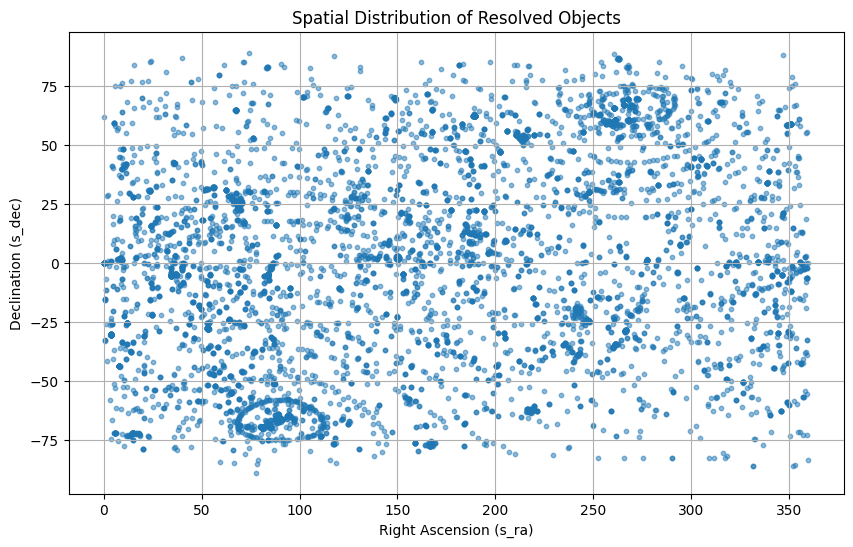

In [182]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plotting the spatial distribution of resolved objects
plt.figure(figsize=(10, 6))
plt.scatter(resolved_df3['s_ra'], resolved_df3['s_dec'], alpha=0.5, s=10)
plt.title('Spatial Distribution of Resolved Objects')
plt.xlabel('Right Ascension (s_ra)')
plt.ylabel('Declination (s_dec)')
plt.grid(True)
plt.show()


In [183]:
resolved_df3

,target_name,s_ra,s_dec,dataset,MJD-OBS,em,coord_block,temp_block,cluster
0,IRAS-05248-7007,81.086467,-70.083778,JWST,59699.184242,3221.5,"(810, -701)",8528,0
1,J1120+0641,170.006167,6.690083,JWST,59945.244998,1147.5,"(1700, 66)",8563,0
2,CEERS-FULL-V2,214.909666,52.872408,JWST,60382.702982,2950.0,"(2149, 528)",8626,0
3,GOODSS2009,53.052791,-27.731936,JWST,60231.322527,2950.0,"(530, -278)",8604,0
4,ABELL2744,3.594322,-30.395694,JWST,60132.288682,3560.0,"(35, -304)",8590,0
...,...,...,...,...,...,...,...,...,...
7837,TESS FFI,118.085778,-54.784110,TESS,60703.535902,800.0,"(1180, -548)",8671,0
7838,TESS FFI,110.714292,-66.099514,TESS,60703.534828,800.0,"(1107, -661)",8671,0
7839,TESS FFI,87.465791,-59.730241,TESS,60703.534831,800.0,"(874, -598)",8671,0
7840,TESS FFI,66.291166,-67.405962,TESS,60703.533629,800.0,"(662, -675)",8671,0


In [184]:
spatial_losers

,target_name,s_ra,s_dec,dataset,MJD-OBS,em,coord_block,temp_block,cluster
0,macs0416_clu_nirspec_targets_v1,64.046035,-24.077283,JWST,60178.660234,2950.0,"(640, -241)",8596,0
1,DG-TAU-B-MIRI2,66.759870,26.092061,JWST,59992.868664,18000.0,"(667, 260)",8570,0
2,2MASS-16514352+6137205,252.931325,61.622358,JWST,59733.814631,2096.5,"(2529, 616)",8533,0
3,UNKNOWN,202.240729,47.137490,JWST,60461.037193,900.0,"(2022, 471)",8637,0
4,HORSEHEAD-FILAMENT,85.223542,-2.467861,JWST,60250.320819,3985.0,"(852, -25)",8607,0
...,...,...,...,...,...,...,...,...,...
639,TESS FFI,271.134075,13.638411,TESS,60492.613113,800.0,"(2711, 136)",8641,0
640,TESS FFI,283.727746,14.631844,TESS,60492.613109,800.0,"(2837, 146)",8641,0
641,TESS FFI,255.172278,74.440969,TESS,60545.814941,800.0,"(2551, 744)",8649,0
642,TESS FFI,282.750015,38.586517,TESS,60492.611292,800.0,"(2827, 385)",8641,0


In [ ]:
class GeneralResolutions(DataFusionPipeline):
    def average_resolution(self, clusters, original_df=None, numeric_cols=None):
        """
        Resolve conflicts by averaging numerical columns.
        For clusters with multiple observations (after filtering for valid indices),
        compute the average of numeric columns. Non-numeric columns come from the first observation.
        """
        if original_df is None:
            original_df = self.df

        res_records = []
        eliminated_indices_avg = []
        log = {'total_clusters': len(clusters),
               'clusters_aggregated': 0,
               'objects_before': len(original_df)}

        if numeric_cols is None:
            numeric_cols = original_df.select_dtypes(include=['number']).columns.tolist()
            
        # Count clusters with more than one index
        multi_instance_clusters = [cluster for cluster in clusters if len(cluster) > 1]
        # print("DDEBUG")
        # print("Total clusters:", len(clusters))
        # print("Clusters with >1 instance:", len(multi_instance_clusters))
        # print("\n")
        # cluster_sizes = [len(cluster) for cluster in clusters]
        # print("Total clusters:", len(cluster_sizes))
        # print("Max cluster size:", max(cluster_sizes))
        # print("Min cluster size:", min(cluster_sizes))
        # print("Average cluster size:", sum(cluster_sizes) / len(cluster_sizes))
        # import collections
        # size_distribution = collections.Counter(cluster_sizes)
        # print("Cluster size distribution:")
        
        # for size, count in sorted(size_distribution.items()):
        #     print(f"  Clusters with size {size}: {count}")
        # print("\n")
        
        for cluster in clusters:
            # Filter cluster indices to those present in original_df.index
            valid_cluster = [idx for idx in cluster if idx in original_df.index]
            if not valid_cluster:
                continue  # skip cluster if no valid indices
            if len(valid_cluster) == 1:
                res_records.append(original_df.loc[valid_cluster[0]])
            else:
                winner_idx = np.random.choice(valid_cluster)   # From the valid possible instances, we will randomly choose one isntead of the first one to ensure diversity 
                log['clusters_aggregated'] += 1
                cluster_df = original_df.loc[valid_cluster]
                avg_values = cluster_df[numeric_cols].mean()
                non_numeric_cols = [col for col in cluster_df.columns if col not in numeric_cols]
                base_data = cluster_df.loc[winner_idx, non_numeric_cols]
                combined = pd.concat([base_data, avg_values])
                res_records.append(combined)
                eliminated_indices_avg.extend([idx for idx in valid_cluster if idx != winner_idx])

        unique_eliminated = set(eliminated_indices_avg)
        eliminated_df = original_df.loc[list(unique_eliminated)].copy()
        eliminated_df = eliminated_df.reset_index(drop=True)
        resolved_df = original_df.drop(index=eliminated_indices_avg, errors='ignore').copy()
        resolved_df = resolved_df.reset_index(drop=True)
        log['objects_after'] = len(resolved_df)
        log['objects_removed'] = len(eliminated_df)
        
                # After building eliminated_indices_avg in average_resolution
        unique_eliminated = set(eliminated_indices_avg)
        # print("DEBUG")
        # print("Unique eliminated indices:", len(unique_eliminated))
        # print("Expected objects removed:", len(original_df) - (len(original_df) - len(unique_eliminated)))
        # print("Difference (objects_before - objects_after):", len(original_df) - len(resolved_df))
        # print("\n")
        return resolved_df, eliminated_df, log

    def get_weighted_average_stats(self, resolution_log):
        print("=== WEIGHTED AVERAGE RESOLUTION STATISTICS ===")
        print(f"Total clusters processed: {resolution_log['total_clusters']}")
        print(f"Clusters aggregated: {resolution_log.get('clusters_aggregated', 0)}")
        print(f"Objects before resolution: {resolution_log['objects_before']}")
        print(f"Objects after resolution: {resolution_log['objects_after']}")
        print(f"Objects removed: {resolution_log['objects_removed']}")
        reduction_rate = (resolution_log['objects_removed'] / resolution_log['objects_before'] * 100 
                          if resolution_log['objects_before'] else 0)
        print(f"Reduction rate: {reduction_rate:.1f}%\n")

    def majority_vote_resolution(self, clusters, original_df=None, column='target_name'):
        """
        Resolve conflicts by majority vote for a specific categorical column.
        For each cluster with multiple observations (after filtering valid indices),
        choose the most common value in the specified column.
        Other columns are taken from the first occurrence.
        """
        if original_df is None:
            original_df = self.df
            
        res_records = []
        eliminated_indices_vote = []
        log = {'total_clusters': len(clusters),
               'clusters_voted': 0,
               'objects_before': len(original_df)}
        
        for cluster in clusters:
            # Filter cluster indices to only those in original_df.index
            valid_cluster = [idx for idx in cluster if idx in original_df.index]
            if not valid_cluster:
                continue
            if len(valid_cluster) == 1:
                res_records.append(original_df.loc[valid_cluster[0]])
            else:
                winner_idx = np.random.choice(valid_cluster) # From the valid possible instances, we will randomly choose one isntead of the first one to ensure diversity 
                log['clusters_voted'] += 1
                cluster_df = original_df.loc[valid_cluster]
                # Get the most frequent value for the specified column
                majority_val = cluster_df[column].value_counts().idxmax()
                chosen = cluster_df.loc[winner_idx].copy()
                chosen[column] = majority_val
                res_records.append(chosen)
                eliminated_indices_vote.extend([idx for idx in valid_cluster if idx != winner_idx])
                
        unique_eliminated = set(eliminated_indices_vote)
        eliminated_df = original_df.loc[list(unique_eliminated)].copy()
        eliminated_df = eliminated_df.reset_index(drop=True)
        resolved_df = original_df.drop(index=eliminated_indices_vote, errors='ignore').copy()
        resolved_df = resolved_df.reset_index(drop=True)
        log['objects_after'] = len(resolved_df)
        log['objects_removed'] = len(eliminated_df)
        
        return resolved_df, eliminated_df, log

    def get_majority_vote_stats(self, resolution_log):
        print("=== MAJORITY VOTE RESOLUTION STATISTICS ===")
        print(f"Total clusters processed: {resolution_log['total_clusters']}")
        print(f"Clusters voted: {resolution_log.get('clusters_voted', 0)}")
        print(f"Objects before resolution: {resolution_log['objects_before']}")
        print(f"Objects after resolution: {resolution_log['objects_after']}")
        print(f"Objects removed: {resolution_log['objects_removed']}")
        reduction_rate = (resolution_log['objects_removed'] / resolution_log['objects_before'] * 100 
                          if resolution_log['objects_before'] else 0)
        print(f"Reduction rate: {reduction_rate:.1f}%\n")

    def random_selection_resolution(self, clusters, original_df=None, seed=None):
        """
        Resolve conflicts by random selection.
        For each cluster with multiple observations (after filtering valid indices),
        randomly choose one instance.
        """
        if original_df is None:
            original_df = self.df
        
        if seed is not None:
            np.random.seed(seed)
            
        res_records = []
        eliminated_indices_random = []
        log = {'total_clusters': len(clusters),
               'clusters_randomized': 0,
               'objects_before': len(original_df)}
        
        for cluster in clusters:
            # Filter cluster indices to those in original_df.index
            valid_cluster = [idx for idx in cluster if idx in original_df.index]
            if not valid_cluster:
                continue
            if len(valid_cluster) == 1:
                res_records.append(original_df.loc[valid_cluster[0]])
            else:
                log['clusters_randomized'] += 1
                selected = np.random.choice(valid_cluster)
                res_records.append(original_df.loc[selected])
                eliminated = [i for i in valid_cluster if i != selected]
                eliminated_indices_random.extend(eliminated)
        
        unique_eliminated = set(eliminated_indices_random)
        eliminated_df = original_df.loc[list(unique_eliminated)].copy()
        eliminated_df = eliminated_df.reset_index(drop=True)
        resolved_df = original_df.drop(index=eliminated_indices_random, errors='ignore').copy()
        resolved_df = resolved_df.reset_index(drop=True)
        log['objects_after'] = len(resolved_df)
        log['objects_removed'] = len(eliminated_df)
        
        return resolved_df, eliminated_df, log

    def get_random_selection_stats(self, resolution_log):
        print("=== RANDOM SELECTION RESOLUTION STATISTICS ===")
        print(f"Total clusters processed: {resolution_log['total_clusters']}")
        print(f"Clusters randomized: {resolution_log.get('clusters_randomized', 0)}")
        print(f"Objects before resolution: {resolution_log['objects_before']}")
        print(f"Objects after resolution: {resolution_log['objects_after']}")
        print(f"Objects removed: {resolution_log['objects_removed']}")
        reduction_rate = (resolution_log['objects_removed'] / resolution_log['objects_before'] * 100 
                          if resolution_log['objects_before'] else 0)
        print(f"Reduction rate: {reduction_rate:.1f}%\n")

In [253]:
def apply_general_resolutions(pipeline, clusters, original_df, method='average', numeric_cols=None, column='target_name', seed=25):
    """
    Example of how to apply general resolutions.
    """
    if method == 'average':
        resolved_df, losers_df, log = pipeline.average_resolution(clusters, original_df, numeric_cols)
        pipeline.get_weighted_average_stats(log)
        return resolved_df, losers_df, log
    elif method == 'majority_vote':
        resolved_df, losers_df, log = pipeline.majority_vote_resolution(clusters, original_df, column)
        pipeline.get_majority_vote_stats(log)
        return resolved_df, losers_df, log
    elif method == 'random_selection':
        resolved_df, losers_df, log = pipeline.random_selection_resolution(clusters, original_df, seed)
        pipeline.get_random_selection_stats(log)
        return resolved_df, losers_df, log
    else:
        raise ValueError("Invalid resolution method. Choose from 'average', 'majority_vote', or 'random_selection'.")

In [264]:
pipe = GeneralResolutions(resolved_df3)
resolved_results1,avg_losers,avg_log = apply_general_resolutions(pipe, clusters, resolved_df3, method='average', numeric_cols=['s_ra', 's_dec','MJD-OBS','em'])

=== WEIGHTED AVERAGE RESOLUTION STATISTICS ===
Total clusters processed: 9163
Clusters aggregated: 411
Objects before resolution: 7842
Objects after resolution: 7245
Objects removed: 597
Reduction rate: 7.6%



In [265]:
pipe = GeneralResolutions(resolved_results1)
resolved_results2,vote_losers,vote_log = apply_general_resolutions(pipe, clusters, resolved_results1, method='majority_vote', numeric_cols=['s_ra', 's_dec','MJD-OBS','em'])

=== MAJORITY VOTE RESOLUTION STATISTICS ===
Total clusters processed: 9163
Clusters voted: 379
Objects before resolution: 7245
Objects after resolution: 6699
Objects removed: 546
Reduction rate: 7.5%



In [266]:
pipe = GeneralResolutions(resolved_results2)
resolved_results3,random_losers,random_log = apply_general_resolutions(pipe, clusters, resolved_results2, method='random_selection', numeric_cols=['s_ra', 's_dec','MJD-OBS','em'])

=== RANDOM SELECTION RESOLUTION STATISTICS ===
Total clusters processed: 9163
Clusters randomized: 355
Objects before resolution: 6699
Objects after resolution: 6191
Objects removed: 508
Reduction rate: 7.6%



In [267]:
print("Average losers equals Majority vote losers:", avg_losers.equals(vote_losers))
print("Average losers equals Random losers:", avg_losers.equals(random_losers))
print("Majority vote losers equals Random losers:", vote_losers.equals(random_losers))

Average losers equals Majority vote losers: False
Average losers equals Random losers: False
Majority vote losers equals Random losers: False


In [268]:
final_df = resolved_results3.copy()
final_df = final_df.reset_index(drop=True)


In [271]:
final_df.drop(columns=['cluster','coord_block','temp_block'])

,target_name,s_ra,s_dec,dataset,MJD-OBS,em
0,IRAS-05248-7007,81.086467,-70.083778,JWST,59699.184242,3221.5
1,J1120+0641,170.006167,6.690083,JWST,59945.244998,1147.5
2,GOODSS2009,53.052791,-27.731936,JWST,60231.322527,2950.0
3,ABELL2744,3.594322,-30.395694,JWST,60132.288682,3560.0
4,UNKNOWN,7.908297,-43.716513,JWST,60620.600387,4433.0
...,...,...,...,...,...,...
6186,TESS FFI,99.457422,-50.090478,TESS,60703.535900,800.0
6187,TESS FFI,118.085778,-54.784110,TESS,60703.535902,800.0
6188,TESS FFI,110.714292,-66.099514,TESS,60703.534828,800.0
6189,TESS FFI,87.465791,-59.730241,TESS,60703.534831,800.0


In [272]:
final_df.to_csv('final_resolved_data.csv', index=False)